### Data Loading

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

In [122]:
cols = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin','embarked', 'survived']
data = pd.read_csv('titanic.csv', usecols=cols)
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.3375,B5,S
1,1,1,male,0.9167,1,2,151.5500,C22,S
2,1,0,female,2.0000,1,2,151.5500,C22,S
3,1,0,male,30.0000,1,2,151.5500,C22,S
4,1,0,female,25.0000,1,2,151.5500,C22,S


### Types of Variable

In [123]:
data.dtypes

,0
pclass,int64
survived,int64
sex,object
age,float64
sibsp,int64
parch,int64
fare,float64
cabin,object
embarked,object


In [124]:
data['pclass'].unique(),data["sibsp"].unique(),data["parch"].unique()

(array([1, 2, 3]),
 array([0, 1, 2, 3, 4, 5, 8]),
 array([0, 2, 1, 4, 3, 5, 6, 9]))

In [125]:
discrete = [var for var in data.columns if data[var].dtype !='O' and var != 'survived' and data[var].nunique() < 10]
continuous = [var for var in data.columns if data[var].dtype !='O' and var != 'survived' and var not in discrete]
mixed = ['cabin']
categorical = [var for var in data.columns if data[var].dtype =='O' and var not in mixed]
len(discrete),len(continuous),len(mixed),len(categorical)

(3, 2, 1, 2)

In [126]:
discrete,continuous,mixed,categorical

(['pclass', 'sibsp', 'parch'], ['age', 'fare'], ['cabin'], ['sex', 'embarked'])

### Variable Charecterestics

In [127]:
# missing data
data.isnull().sum()

,0
pclass,0
survived,0
sex,0
age,263
sibsp,0
parch,0
fare,1
cabin,1014
embarked,2


In [128]:
# cardinality
data[discrete+categorical+mixed].nunique()

,0
pclass,3
sibsp,7
parch,8
sex,2
embarked,3
cabin,181


<Axes: >

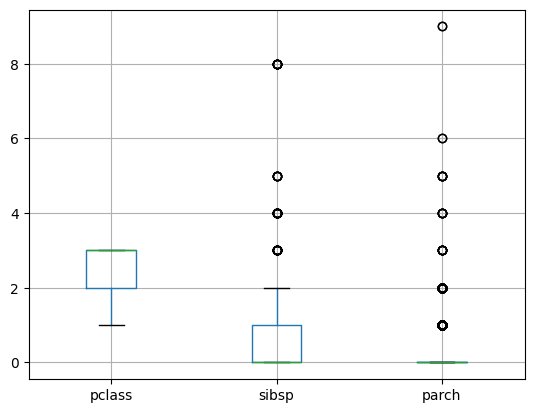

In [129]:
# outliers
data[discrete].boxplot()

<Axes: >

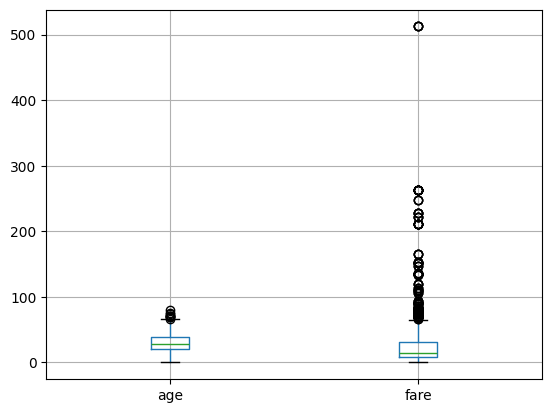

In [130]:
data[continuous].boxplot()

In [131]:
# more than 3 are all outliers
data["parch"].value_counts()

,count
parch,
0,1002
1,170
2,113
3,8
4,6
5,6
6,2
9,2


In [132]:
# feature magnitude
data.describe()

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


### Mixed Variable

In [133]:
data['cabin_num'] = data['cabin'].str.extract('(\d+)')
data['cabin_num'] = data['cabin_num'].astype('float')
data['cabin_cat'] = data['cabin'].str[0]

In [134]:
data.drop(['cabin'],axis=1,inplace=True)

In [135]:
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,cabin_num,cabin_cat
0,1,1,female,29.0000,0,0,211.3375,S,5.0,B
1,1,1,male,0.9167,1,2,151.5500,S,22.0,C
2,1,0,female,2.0000,1,2,151.5500,S,22.0,C
3,1,0,male,30.0000,1,2,151.5500,S,22.0,C
4,1,0,female,25.0000,1,2,151.5500,S,22.0,C


In [136]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('survived', axis=1), data['survived'],  test_size=0.1,  random_state=0)
X_train.shape, X_test.shape

((1178, 9), (131, 9))

## Feature Engineering Pipeline

In [137]:
from sklearn.preprocessing import FunctionTransformer

In [138]:
# missing data
def impute_numeric(data):
    data = data.copy()
    data[['age', 'fare', 'cabin_num']] = data[['age', 'fare', 'cabin_num']].fillna(-1)
    return data

def impute_categoric(data):
    data = data.copy()
    most_frequent_values = data[['embarked', 'cabin_cat']].mode().iloc[0]
    data[['embarked', 'cabin_cat']] = data[['embarked', 'cabin_cat']].fillna(most_frequent_values)
    return data

# categorical encoding
def ordinal_encoding(data):
    data = data.copy()
    ordinal_map_sex = {k: i for i, k in enumerate(data["sex"].unique(), 0)}
    ordinal_map_embarked = {k: i for i, k in enumerate(data["embarked"].unique(), 0)}
    data["sex"] = data["sex"].map(ordinal_map_sex)
    data["embarked"] = data["embarked"].map(ordinal_map_embarked)
    return data

def find_non_rare_labels(df, variable, tolerance):
    temp = df.groupby(variable)[variable].count() / len(df)
    non_rare = temp[temp > tolerance].index.tolist()
    return non_rare

def rare_encoding(data, variable, tolerance=0.01):
    data = data.copy()
    frequent_cat = find_non_rare_labels(data, variable, tolerance)
    data[variable] = np.where(data[variable].isin(frequent_cat), data[variable], "Rare")
    ordinal_map = {k: i for i, k in enumerate(data[variable].unique(), 0)}
    data[variable] = data[variable].map(ordinal_map)
    return data

In [139]:
titanic_pipe = Pipeline([
    ('impute_num', FunctionTransformer(impute_numeric)),
    ('impute_cat', FunctionTransformer(impute_categoric)),
    ('ordinal_enc', FunctionTransformer(ordinal_encoding)),
    ('rare_encoding', FunctionTransformer(lambda X: rare_encoding(X, variable='cabin_cat', tolerance=0.01))),
    ('gbm', GradientBoostingClassifier(n_estimators=15, random_state=0))
])

In [140]:
titanic_pipe.fit(X_train, y_train)

Pipeline(steps=[('impute_num',
                 FunctionTransformer(func=<function impute_numeric at 0x7f4c5cc71ee0>)),
                ('impute_cat',
                 FunctionTransformer(func=<function impute_categoric at 0x7f4c5cc71440>)),
                ('ordinal_enc',
                 FunctionTransformer(func=<function ordinal_encoding at 0x7f4c5cc714e0>)),
                ('rare_encoding',
                 FunctionTransformer(func=<function <lambda> at 0x7f4c5cc72c00>)),
                ('gbm',
                 GradientBoostingClassifier(n_estimators=15, random_state=0))])

In [141]:
X_train_preds = titanic_pipe.predict_proba(X_train)[:,1]
X_test_preds = titanic_pipe.predict_proba(X_test)[:,1]

In [142]:
X_train_preds

array([0.23889851, 0.17169736, 0.39971624, ..., 0.56389856, 0.83727962,
       0.4969203 ])

In [143]:
print('Train set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

print('Test set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Train set
GBM roc-auc: 0.8677411687266876
Test set
GBM roc-auc: 0.8177710843373494


<Axes: >

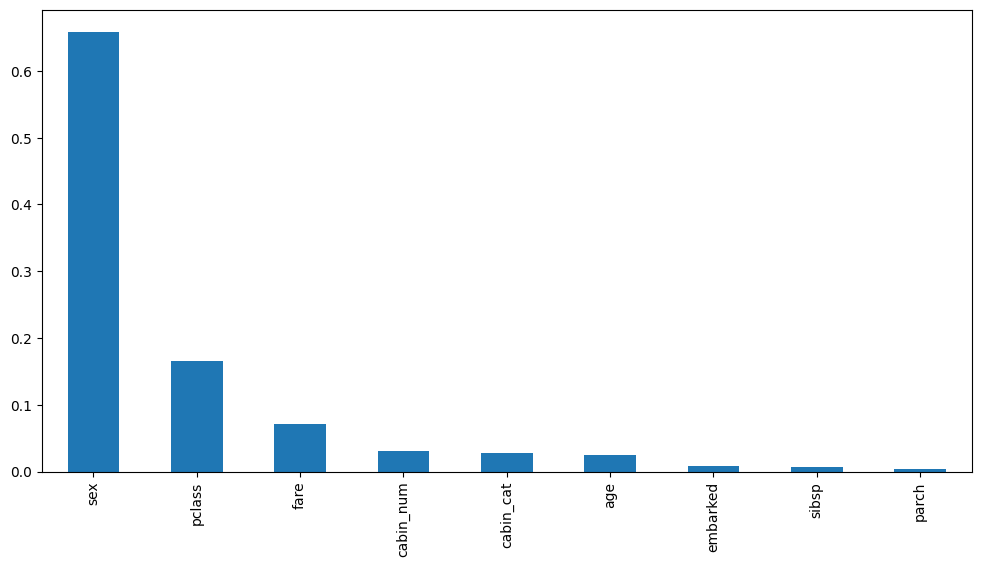

In [144]:
importance = pd.Series(titanic_pipe.named_steps['gbm'].feature_importances_)
importance.index = data.drop('survived', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

## Hyperparameter(Cross Validation)

In [145]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

In [146]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [153]:
param_grid = {
    'gbm__n_estimators': [15,50,100]
}

In [154]:
grid_search = GridSearchCV(
    estimator=titanic_pipe,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'gbm__n_estimators': 100}
Best Score: 0.8039163360980887


In [155]:
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Accuracy:", test_score)

Test Accuracy: 0.7862595419847328
